In [2]:
import numpy as np
import math
import cv2
import os
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

from skimage.feature import local_binary_pattern

from scipy.signal import gaussian
from scipy.signal import argrelextrema

from PIL import Image
from PIL.TiffTags import TAGS

# Helper functions

Implement any commonly used functions here.

In [ ]:
def my_imshow(rows, cols, images, cmap='gray'):
    """
    This function displays images in a (rows x cols) grid.

    Parameters:
    rows (int): The number of rows in the grid of subplots.
    cols (int): The number of columns in the grid of subplots.
    images (list): A list of images to display row by row on the grid.
    cmap (string): Custom colur map for imshow(). Default: 'gray'

    Returns:
    No return value.
    """
    # Handle boundary conditions
    if len(images) > rows * cols:
        raise Exception('Number of images passed exceeds dimensions of grid')
    
    subfigs = []
    fig = plt.figure(figsize = (cols * 7, rows * 7))

    # Add subplots into the grid
    for i in range(rows):
        for j in range(cols):
            subfigs.append(fig.add_subplot(rows, cols, i * cols + j + 1))

    # Show images on the subplots created
    for i in range(len(images)):
        if cmap == 'gray':
            subfigs[i].imshow(images[i], cmap='gray', vmin=0, vmax=255)
        else:
            subfigs[i].imshow(images[i], cmap=cmap)

def write_tiff(tiff_template, dest_path, img):    
    """
    This function saves an input image as a TIFF image with metadata.

    Parameters:
    tiff_template (TIFF image): A sample TIFF image whose metadata is used as a template.
    dest_path (string): Output path at which the TIFF image is to be saved.
    img (np.ndarray): A histogram thresholded image from the dataset.

    Returns:
    No return value.
    """
    out = Image.fromarray(img)
    out.save(dest_path, tiffinfo = tiff_template.tag_v2)

def get_tiff_dict(path):
    """
    This function finds all sub-directories of path containing .tiff files

    Parameters:
    path (string): Parent directory to search for .tiff files.

    Returns:
    tiff_dirs (dict): A dictionary in which key: sub-directory, value: list of all .tiff files within the sub-directory
    """
    # Get the paths of all .tiff files in the sub-directories of path
    tiff_files = Path(path).rglob('*.tiff')
    tiff_dirs = {}

    # Form a list of tiff files within the same directory and add it
    # to the dict tiff_dirs with the directory path as key
    for tiff_file in tiff_files:
        tiff_file = str(tiff_file)
        if tiff_file.split('/')[-1][0] == '.':
            continue

        tiff_dir = '/'.join(tiff_file.split('/')[: -1])
        if tiff_dir in tiff_dirs.keys():
            tiff_dirs[tiff_dir].append(tiff_file)
        else:
            tiff_dirs[tiff_dir] = [tiff_file]
    
    return tiff_dirs

def get_png_dict(path):
    """
    This function finds all sub-directories of path containing .png files

    Parameters:
    path (string): Parent directory to search for .png files.

    Returns:
    png_dirs (dict): A dictionary in which key: sub-directory, value: list of all .png files within the sub-directory
    """
    # Get the paths of all .png files in the sub-directories of path
    png_files = Path(path).rglob('*.png')
    png_dirs = {}

    # Form a list of png files within the same directory and add it
    # to the dict png_dirs with the directory path as key
    for png_file in png_files:
        png_file = str(png_file)
        if png_file.split('/')[-1][0] == '.':
            continue
            
        png_dir = '/'.join(png_file.split('/')[: -1])
        if png_dir in png_dirs.keys():
            png_dirs[png_dir].append(png_file)
        else:
            png_dirs[png_dir] = [png_file]
    
    return png_dirs

def create_tiff_videos(path):
    """
    This function makes a video out of all the .tiff files present in path

    Parameters:
    path (string): Parent directory containing the .tiff files

    Returns:
    No return value.
    """
    # Get all the directories in path containing .tiff files
    tiff_dirs = get_tiff_dict(path)

    # Create a video for all the directories found
    for tiff_dir in tiff_dirs.keys():
        size = ()
        
        img = cv2.imread(tiff_dirs[tiff_dir][0])
        height, width, layers = img.shape
        size = (width, height)
        save_path = 'data/' + tiff_dir.split('/')[-1]

        out = cv2.VideoWriter(save_path + '.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
        
        for tiff_file in sorted(tiff_dirs[tiff_dir]):
            img = cv2.imread(tiff_file)
            out.write(img)
        
        out.release()

def normalize(img):
    """
    Normalize the image to improve contrast

    Parameters:
    img (np.ndarray): Input image to normalize

    Returns:
    img (np.ndarray): Normalized input image
    """
    return cv2.equalizeHist(img)

# Global variables

In [ ]:
# Define global variables used further in the notebook
dataset_root = '../input/'
dataset_paths = ['s_o5', 's_o75', 's_1', 's_1o25', 's_1o5', 's_1o75', 's_2', 's_3', 's_3']

# Convert all datasets to videos (for better visualization)

In [ ]:
# create_tiff_videos('/media/chethan749/Honeycomb/combined/')

# Histogram thresholding foreground segmentation

This method to segment foreground honeycomb from the background worked best. The method is implemented as follows:
* Get the histogram for the image
* Remove count of black pixels as they are the highest and not relevant to our task
* After removing black pixels, the highest peak corresponds to background. Make all the pixels corresponding to this peak black, effectively removing background
* Generate a mask of the foreground generated in the previous step
* Open and dilate the mask to remove noise and make honeycomb structures clear

<!-- TODOs:
* Honey still remains part of foreground - Segment it out (Low prioirty) -->

In [7]:
# Get the foreground image using histogram thresholding
# Foreground - Honeycomb, Plastic frame
# Background - Air
def get_hist_fg(img):
    """
    This function computes the foreground mask for a single unprocessed dataset image.

    Parameters:
    img (np.ndarray): A unprocessed image from the dataset.

    Returns:
    mask (np.ndarray): Foreground mask (excludes air pixels).
    hist (np.ndarray): Histogram of the image.
    start (int): Foreground threshold pixel intensity.
    """
    # Gaussian blur to reduce image noise
    blurred_img = cv2.GaussianBlur(img, (7, 7), 0)

    # Calculate histogram of image
    hist = cv2.calcHist([blurred_img], [0], None, [256], [0,256])
    hist = np.squeeze(hist)
    hist[0] = 0

    # Find the pixel intensity (x-value) corresponding to the highest peak
    # The pixel-intensities falling under this peak correspond to air
    peak = np.argmax(hist)
    
    # Heuristic to find the pixel-intensity corresponding to the right-side base of the peak
    start = peak + 3
    derivative = np.gradient(hist)
    slope = derivative[start]
    
    for i in range(peak + 3, 256):
        if derivative[i] / slope < 0.025:
            break
        start += 1

    # Morphological operations to remove noise and enhance the foreground
    mask = np.where(img > start, 255, 0).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), 0)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

    return mask, hist, start

## Driver function for histogram thresholding

In [ ]:
def histogram_thresh(path):
    """
    This is a driver function to compute the foreground of unprocessed dataset images using get_hist_fg().
    This function also computes the average proportion of air pixels in the dataset.

    Parameters:
    path (string): Dataset path.

    Returns:
    pd.DataFrame: Creates a pd.DataFrame with a column containing the proportion of air pixels, indexed by the dataset name.
    """
    tiff_dirs = get_tiff_dict(path)
    air_pixels_proportion_dict = {}
    air_pixels_proportion_list = []

    for tiff_dir in sorted(tiff_dirs.keys()):
        hist_solution_path = f'{tiff_dir}/hist_threshold/'

        # Find the sub-directory within the dataset path containing the raw images
        try:
            tiff_template = Image.open(f'{tiff_dir}/0001.tiff')
        except:
            continue # Solution dir

        # Create the output directory if it doesn't exist already
        if not os.path.isdir(hist_solution_path):
            os.makedirs(hist_solution_path)

        if not os.path.isdir(f'{hist_solution_path}/tiff/'):
            os.makedirs(f'{hist_solution_path}/tiff/')

        temp_img = cv2.imread(tiff_dirs[tiff_dir][0], cv2.IMREAD_GRAYSCALE)
        out = cv2.VideoWriter(hist_solution_path + tiff_dir.split('/')[-1] + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (temp_img.shape[1], temp_img.shape[0]))

        print('Begin computing foreground of ' + tiff_dir)
        for i, file in tqdm(enumerate(sorted(tiff_dirs[tiff_dir]))):
            # Read a dataset image
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            # Call the histogram foreground thresholding function
            mask, hist, thresh = get_hist_fg(img)
            masked_image = cv2.bitwise_and(img, mask)

            ### Compute the average proportion of air pixels in the dataset
            total_pixels = img.shape[0] * img.shape[1]
            black_pixels = img[img == 0].shape[0]
            foreground_pixels = mask[mask > 0].shape[0]
            air_pixels = total_pixels - black_pixels - foreground_pixels
            air_pixels_proportion = air_pixels / (total_pixels - black_pixels)
            air_pixels_proportion_list.append(air_pixels_proportion)

            # Save the thresholded image as a TIFF image
            tiff_image = cv2.imread(file, -1)
            tiff_masked = cv2.bitwise_and(tiff_image, (mask > 0).astype(np.uint16) * 0xffff)
            write_tiff(tiff_template, f'{hist_solution_path}/tiff/{i}.tiff', tiff_masked)

            # Add the thresholded image into the dataset video
            out.write(cv2.cvtColor(masked_image, cv2.COLOR_GRAY2BGR))
        print('Finish computing foreground of ' + tiff_dir)

        air_pixels_proportion_dict[path.split(os.path.sep)[-1]] = np.mean(air_pixels_proportion_list)
        out.release()

    return pd.DataFrame.from_dict(air_pixels_proportion_dict, orient = 'index', columns = ['AirProportion'])

In [ ]:
# Placeholder to store the proporition of air pixels in each dataset
air_pixels_proportion_df_list = []

# Call histogram_thresh() on the required datasets
for dataset_path in dataset_paths:
    if os.path.isdir(dataset_root + dataset_path):
        air_pixels_proportion_df_list.append(histogram_thresh(dataset_root + dataset_path))

# Create a single dataset containing the proportion of air pixels for all datasets
air_pixels_proportion_df = pd.concat(air_pixels_proportion_df_list)

Begin computing foreground of /media/chethan749/Honeycomb1/combined/wax_o5x/o5x_no_honey/o5x_no_honey_2022-12-26_125835/0.4X 95kVA/o5x_no_honey_0.4X 95kVA_recon


2034it [11:04,  3.06it/s]


Finish computing foreground of /media/chethan749/Honeycomb1/combined/wax_o5x/o5x_no_honey/o5x_no_honey_2022-12-26_125835/0.4X 95kVA/o5x_no_honey_0.4X 95kVA_recon
Begin computing foreground of /media/chethan749/Honeycomb1/combined/wax_o5x/wax_o5x/wax_o5x_2022-12-26_110135/0.4X 95kV/wax_o5x_0.4X 95kV_recon


2034it [10:43,  3.16it/s]


Finish computing foreground of /media/chethan749/Honeycomb1/combined/wax_o5x/wax_o5x/wax_o5x_2022-12-26_110135/0.4X 95kV/wax_o5x_0.4X 95kV_recon
Begin computing foreground of /media/chethan749/Honeycomb1/combined/wax_o75x/wax_o75_no_honey/wax_o75_no_honey_2022-12-07_122440/0.4X 90kV/wax_o75_no_honey_0.4X 90kV_recon


2034it [10:55,  3.10it/s]


Finish computing foreground of /media/chethan749/Honeycomb1/combined/wax_o75x/wax_o75_no_honey/wax_o75_no_honey_2022-12-07_122440/0.4X 90kV/wax_o75_no_honey_0.4X 90kV_recon
Begin computing foreground of /media/chethan749/Honeycomb1/combined/wax_1x/wax_1x_no_honey_trial2_2022-12-07_134615/0.4X 95kV/wax_1x_no_honey_trial2_0.4X 95kV_recon


2034it [11:42,  2.90it/s]


Finish computing foreground of /media/chethan749/Honeycomb1/combined/wax_1x/wax_1x_no_honey_trial2_2022-12-07_134615/0.4X 95kV/wax_1x_no_honey_trial2_0.4X 95kV_recon
Begin computing foreground of /media/chethan749/Honeycomb1/combined/1o25/1o25_2023-10-19_141536/0.4X 85kV 17.4um/1o25_0.4X 85kV 17.4um_recon


2034it [11:08,  3.04it/s]


Finish computing foreground of /media/chethan749/Honeycomb1/combined/1o25/1o25_2023-10-19_141536/0.4X 85kV 17.4um/1o25_0.4X 85kV 17.4um_recon
Begin computing foreground of /media/chethan749/Honeycomb1/combined/wax_1o5x


2034it [11:01,  3.08it/s]


Finish computing foreground of /media/chethan749/Honeycomb1/combined/wax_1o5x
Begin computing foreground of /media/chethan749/Honeycomb1/combined/wax_1o75x_small/1o75_small_2023-08-30_132806/0.4X 95kVA/1o75_small_0.4X 95kVA_recon


2034it [11:07,  3.05it/s]


Finish computing foreground of /media/chethan749/Honeycomb1/combined/wax_1o75x_small/1o75_small_2023-08-30_132806/0.4X 95kVA/1o75_small_0.4X 95kVA_recon
Begin computing foreground of /media/chethan749/Honeycomb1/combined/wax_1o75x/1o75x_2023-08-30_121031/0.4X 95kVA/1o75x_0.4X 95kVA_recon


2028it [11:30,  2.94it/s]


Finish computing foreground of /media/chethan749/Honeycomb1/combined/wax_1o75x/1o75x_2023-08-30_121031/0.4X 95kVA/1o75x_0.4X 95kVA_recon
Begin computing foreground of /media/chethan749/Honeycomb1/combined/1o75-redo/1o75-redo_2023-09-28_101351/0.4X 85kV 17.4um/1o75-redo_0.4X 85kV 17.4um_recon


2028it [11:34,  2.92it/s]


Finish computing foreground of /media/chethan749/Honeycomb1/combined/1o75-redo/1o75-redo_2023-09-28_101351/0.4X 85kV 17.4um/1o75-redo_0.4X 85kV 17.4um_recon
Begin computing foreground of /media/chethan749/Honeycomb1/combined/wax_2x


1016it [01:47,  9.45it/s]


Finish computing foreground of /media/chethan749/Honeycomb1/combined/wax_2x
Begin computing foreground of /media/chethan749/Honeycomb1/combined/wax_3x/zoomed_in_1/wax_3x_zoomed_in_1_recon


2034it [12:42,  2.67it/s]


Finish computing foreground of /media/chethan749/Honeycomb1/combined/wax_3x/zoomed_in_1/wax_3x_zoomed_in_1_recon
Begin computing foreground of /media/chethan749/Honeycomb1/combined/wax_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon


2034it [12:35,  2.69it/s]


Finish computing foreground of /media/chethan749/Honeycomb1/combined/wax_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon


In [131]:
air_pixels_proportion_df

,AirProportion
wax_o5x,0.844772
wax_o75x,0.894593
wax_1x,0.886136
1o25,0.889083
wax_1o5x,0.890567
wax_1o75x_small,0.889560
wax_1o75x,0.888819
1o75-redo,0.891748
wax_2x,0.877028
zoomed_in_1,0.851321


## Test the function `get_hist_fg()`:

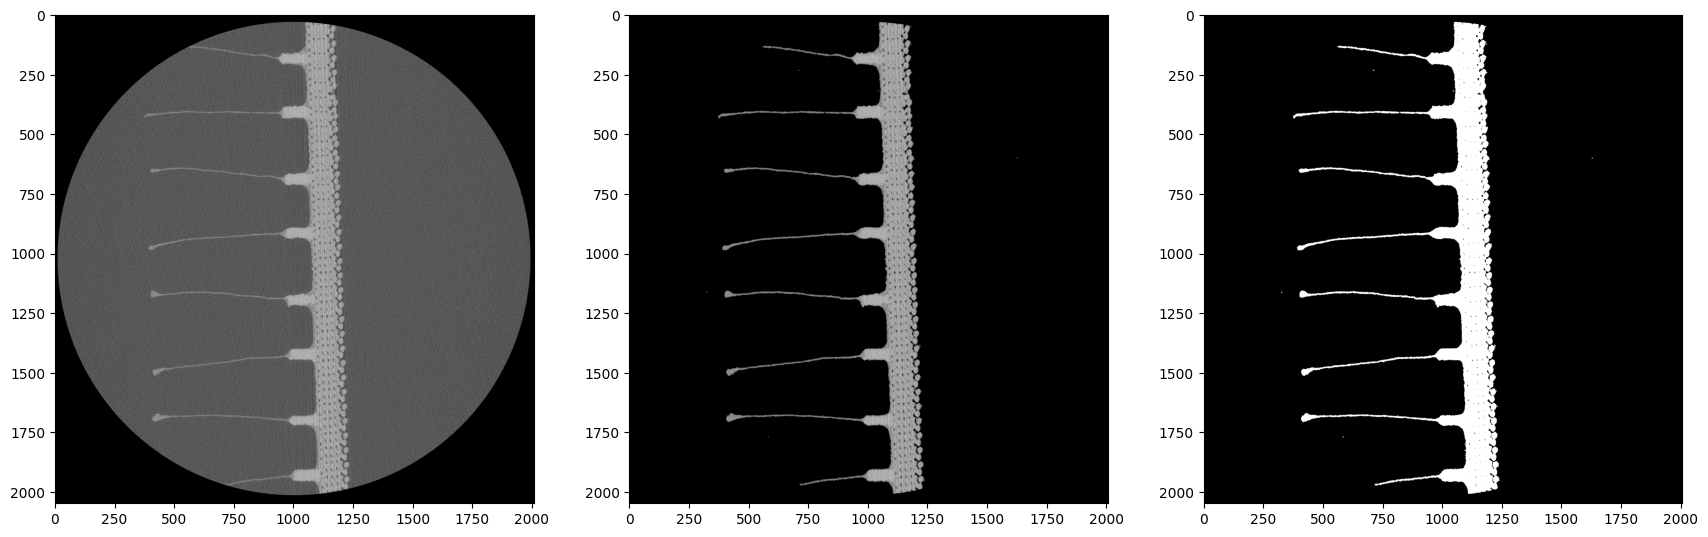

In [ ]:
# img = cv2.imread('../input/s_o5/0500.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_o75/0540.tiff')
img = cv2.imread('../input/s_1/0840.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_1o25/440.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_1o5/940.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_1o75/0621.tiff')
# img = cv2.imread('../input/s_2/0452.tiff')
# img = cv2.imread('../input/s_3/0630.tiff')

mask, hist, thresh = get_hist_fg(img)
masked_image = cv2.bitwise_and(img, mask)
my_imshow(1, 3, [img, masked_image, mask])

## Plot the histogram of pixel intensities as a PMF

Essentially this plot is a PMF of the pixel intesnities and the threshold value used to subract out background noise is shown as a dashed line.
* X-axis - Pixel intensities
* Y-axis - Proportion

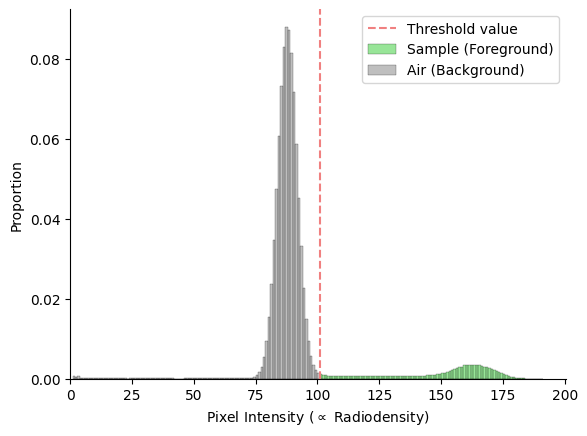

In [ ]:
# Create a pd.DataFrame containing all pixel intensities in the blurred image
hist_fg_image_df = pd.DataFrame(cv2.GaussianBlur(img, (7, 7), 0).flatten(), columns=['PixelIntensity'])
mask = hist_fg_image_df.PixelIntensity < thresh

fig, axes = plt.subplots()

# Plot the histogram, with bars appropriately colored
ax = sns.histplot(data = hist_fg_image_df[hist_fg_image_df.PixelIntensity > 0], 
                  x = 'PixelIntensity', 
                  binwidth = 1,
                  stat = 'proportion', 
                  hue=mask,
                  palette={True: 'gray', False: 'limegreen'},
                  element='bars', 
                  hue_order=[True, False],
                  legend=True, 
                  ax = axes)

# Mark the threshold value used for foreground segmentation
ax.axvline(x=thresh, c='lightcoral', ls='dashed', label = 'Threshold value')

ax.legend(['Threshold value', 'Sample (Foreground)', 'Air (Background)'])

ax.set_xlim(left = 0)
ax.set_xlabel(r'Pixel Intensity ($\propto$ Radiodensity)')

sns.despine()

# Save the figure
ax.figure.savefig('figures/histogram_segmentation.png', dpi=600)

# Plastic base filtering using kernel convolution

The following steps are done to segment plastic regions from images:
* Construct a 20x20 kernel in which the first half of the columns are all 1s and the second half of the columns are all -1s (or vice-versa depending on the relative positions of the honeycomb and the plastic starter in the dataset).
* Convolve this kernel over an image in the dataset. The kernel can be imagined to be a sliding window over the image, sliding over the image row by row.
* For each row of sliding the kernel over the image, identify the point where kernel convolution gives the maximum value. Due to the nature of the kernel design, this point in the row corresponds to the boundary of the plastic base and air.
* Dilate the identified boundary points obtained to fill the entire plastic region (dilation iterations is a parameter which needs to be tuned for each dataset).
* Obtain a bounding box for the dilated contour. This bounding box serves as the mask of plastic region in the slice.

The ideal values of parameters for each dataset can be found below.

In [311]:
def get_plastic_mask_sliding_window(img, left, dilation_iters):
    """
    This function computes the plastic base mask for a single histogram-thresholded dataset image.

    Parameters:
    img (np.ndarray): A histogram thresholded image from the dataset.
    left (bool): Switch to indicate the relative position of the honeycomb to the plastic base.
    dilation_iters (int): A tunable parameter to control the degree of dilation while creating the mask.

    Returns:
    np.ndarray: Mask to use to filter out the plastic base.
    """
    mask = np.zeros(img.shape)
    plastic_rect = np.zeros(img.shape)

    kernel_rows = 300
    kernel_cols = 100
        
    # Create the kernel to identify the boundary of the plastic base and air
    kernel = np.ones((kernel_rows, kernel_cols))
    if left:
        kernel[:, 50:] = -1
        col_range = np.arange(img.shape[1] - kernel_cols, 0, -10)
    else:
        kernel[:, :50] = -1
        col_range = np.arange(0, img.shape[1] - kernel_cols, 10)

    # Convolve the image with the kernel by using it as a sliding window
    for i in range(0, img.shape[0] - kernel_rows, kernel_rows):
        highest = 0
        highest_index = -1
        for j in col_range:
            # Heuristic to mark the boundary of the plastic base and air
            if np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel) > highest:
                highest = np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel)
                highest_index = j

        if left:
            mask[i: i + kernel_rows, highest_index + 90: highest_index + 120] = 255
        else:
            mask[i: i + kernel_rows, highest_index: highest_index + 30] = 255

    # Convolve the last strip that gets excluded above
    i = img.shape[0] - kernel_rows
    highest = 0
    highest_index = -1
    for j in col_range:
        # Heuristic to mark the boundary of the plastic base and air
        if np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel) > highest:
            highest = np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel)
            highest_index = j
    
    if left:
        mask[i: i + kernel_rows, highest_index + 90: highest_index + 120] = 255
    else:
        mask[i: i + kernel_rows, highest_index: highest_index + 30] = 255

    # Create a contour of the identified boundary
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_contour_wo_dilation = max(contours, key = cv2.contourArea)

    # Find the bounding box for this contour
    rect = cv2.minAreaRect(max_contour_wo_dilation)
    box = cv2.boxPoints(rect)
    plastic_box_wo_dilation = np.intp(box)

    # Dilate to create the final mask
    cv2.drawContours(plastic_rect, [plastic_box_wo_dilation], -1, (255, 255, 255), -1)
        
    dilated_result = cv2.dilate(plastic_rect.astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)), iterations = dilation_iters)
    
    return dilated_result

## Mask out plastic base for o5x and o75x data

There is a different function for o5x because this dataset differs from previous datasets in the following ways:
* There is honey present below the starter
* A lot of wax is present on the above surface of the starter as well due to which the previous function (LBP TM) did not produce good results.

The method used to segment the plastic base for o5x and o75x is the same as earlier, but the kernel used as the sliding window differs to accomodate for the above peculariaties in the data for these cell sizes.

In [308]:
def get_plastic_mask_sliding_window_o5x(img, left, dilation_iters):
    """
    This function computes the plastic base mask for a single histogram-thresholded o5x or o75x image.
    We have a separate function for o5x and o75x because it is not as clean as the other datasets and needs special handling.

    Parameters:
    img (np.ndarray): A histogram thresholded image from the dataset.
    
    Returns:
    np.ndarray: Mask to use to filter out the plastic base.
    """
    mask = np.zeros(img.shape)
    plastic_rect = np.zeros(img.shape)

    kernel_rows = 300
    kernel_cols = 100
        
    # Create the kernel to identify the boundary of the plastic base and air
    kernel = np.ones((kernel_rows, kernel_cols))
    # o5x data
    kernel[:, 35:65] = -1
    if left:
        col_range = np.arange(img.shape[1] - kernel_cols, 0, -10)
    else:
        col_range = np.arange(0, img.shape[1] - kernel_cols, 10)

    # Convolve the image with the kernel by using it as a sliding window
    for i in range(0, img.shape[0] - kernel_rows, kernel_rows):
        highest = 0
        highest_index = -1
        for j in col_range:
            # Heuristic to mark the boundary of the plastic base and air
            if np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel) > highest:
                highest = np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel)
                highest_index = j

        if left:
            mask[i: i + kernel_rows, highest_index + 90: highest_index + 120] = 255
        else:
            mask[i: i + kernel_rows, highest_index: highest_index + 30] = 255

    # Convolve the last strip that gets excluded above
    i = img.shape[0] - kernel_rows
    highest = 0
    highest_index = -1
    for j in col_range:
        # Heuristic to mark the boundary of the plastic base and air
        if np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel) > highest:
            highest = np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel)
            highest_index = j
    
    if left:
        mask[i: i + kernel_rows, highest_index + 90: highest_index + 120] = 255
    else:
        mask[i: i + kernel_rows, highest_index: highest_index + 30] = 255

    # Create a contour of the identified boundary
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_contour_wo_dilation = max(contours, key = cv2.contourArea)

    # Find the bounding box for this contour
    rect = cv2.minAreaRect(max_contour_wo_dilation)
    box = cv2.boxPoints(rect)
    plastic_box_wo_dilation = np.intp(box)

    # Dilate to create the final mask
    cv2.drawContours(plastic_rect, [plastic_box_wo_dilation], -1, (255, 255, 255), -1)
    dilated_result = cv2.dilate(plastic_rect.astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)), iterations = dilation_iters)
    
    return dilated_result

## Driver function to fliter out the plastic base

In [309]:
def filter_out_plastic_base(path, left, iters):
    """
    Driver function to compute the plastic base masks for the dataset images

    Parameters:
    path (string): Path to the top level directory of the dataset.
    left (bool): Switch to indicate the relative position of the honeycomb to the plastic base.
    dilation_iters (int): A tunable parameter to control the degree of dilation while creating the mask.

    Returns:
    No return value.
    """
    tiff_dirs = get_tiff_dict(path)

    for tiff_dir in sorted(tiff_dirs.keys()):
        plastic_base_masked_solution_path = f'{tiff_dir}/../../plastic_base_masked/'

        # Find the input sub-directory in the dataset directory
        if not 'hist_threshold' in tiff_dir:
            continue

        try:
            tiff_template = Image.open(f'{tiff_dir}/../../0001.tiff')
        except:
            continue # Solution dir

        # Create the output directory if it does not already exist
        if not os.path.isdir(plastic_base_masked_solution_path):
            os.makedirs(plastic_base_masked_solution_path)

        if not os.path.isdir(f'{plastic_base_masked_solution_path}/tiff/'):
            os.makedirs(f'{plastic_base_masked_solution_path}/tiff/')

        temp_img = cv2.imread(tiff_dirs[tiff_dir][0], cv2.IMREAD_GRAYSCALE)
        plastic_base_masked_out = cv2.VideoWriter(plastic_base_masked_solution_path + tiff_dir.split('/')[-3] + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (temp_img.shape[1], temp_img.shape[0]))

        print('Begin computing foreground of ' + tiff_dir)
        for i, file in tqdm(enumerate(sorted(tiff_dirs[tiff_dir], key = lambda x: int(x.split(os.path.sep)[-1].split('.')[0])))):
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            tiff_image = cv2.imread(file, -1)
            
            # Get plastic base mask from get_plastic_mask_sliding_window()
            dataset = path.split(os.path.sep)[-1]
            if dataset == 'wax_o5x' or dataset == 'wax_o75x':
                plastic_mask = get_plastic_mask_sliding_window_o5x(img, left, iters)
            else:
                plastic_mask = get_plastic_mask_sliding_window(img, left, iters)

            plastic_base_masked_image = cv2.bitwise_and(img, 255 - plastic_mask)
            tiff_plastic_base_masked = cv2.bitwise_and(tiff_image, ((255 - plastic_mask) > 0).astype(np.uint16) * 0xffff)
            write_tiff(tiff_template, f'{plastic_base_masked_solution_path}/tiff/{i}.tiff', tiff_plastic_base_masked)
            plastic_base_masked_out.write(cv2.cvtColor(plastic_base_masked_image, cv2.COLOR_GRAY2BGR))


        plastic_base_masked_out.release()

In [ ]:
# We are not doing o5x here because the data is not as clean and therefore we have a separate function to remove
# the plastic starter for o5x
plastic_base_mask_parameters = {
    's_o5': [True, 9], # o5x
    's_o75': [False, 7], # o75x
    's_1': [True, 14], # 1x
    's_1o25': [True, 13], # 1o25x
    's_1o5': [True, 13], # 1o5x
    's_1o75': [False, 13], # 1o75x
    's_2': [True, 9], # 2x
    's_3': [True, 18], # 3x
}

# Mask out the plastic base for the required datasets
dataset_root = '../input/'

for dataset_path in dataset_paths:
    if os.path.isdir(dataset_root + dataset_path + '/hist_threshold'):
        filter_out_plastic_base(dataset_root + dataset_path, plastic_base_mask_parameters[dataset_path][0], plastic_base_mask_parameters[dataset_path][1])

Begin computing foreground of /media/chethan749/Honeycomb1/combined/wax_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon/hist_threshold/tiff


2034it [33:00,  1.03it/s]


## Test the function `get_plastic_mask_sliding_window()`

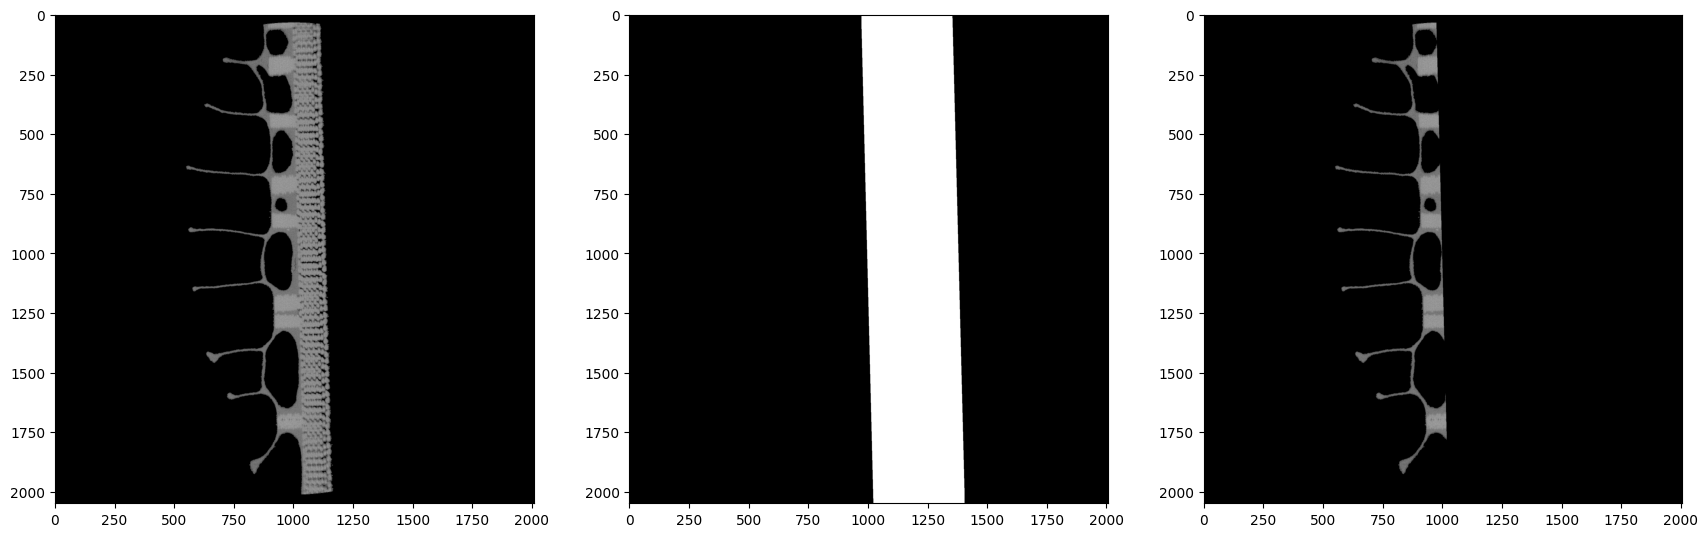

In [ ]:
# img = cv2.imread('../input/s_1/hist_threshold/tiff/125.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_1o25/hist_threshold/tiff/380.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_1o5/hist_threshold/tiff/340.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_1o75/hist_threshold/tiff/212.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_2/hist_threshold/tiff/532.tiff', cv2.IMREAD_GRAYSCALE)
img = cv2.imread('../input/s_3/hist_threshold/tiff/950.tiff', cv2.IMREAD_GRAYSCALE)

plastic_mask = get_plastic_mask_sliding_window(img, True, 14)
plastic_base_masked_image = cv2.bitwise_and(img, 255 - plastic_mask)
my_imshow(1, 3, [img, plastic_mask, plastic_base_masked_image])

## Test the function `get_plastic_mask_sliding_window_o5x()`

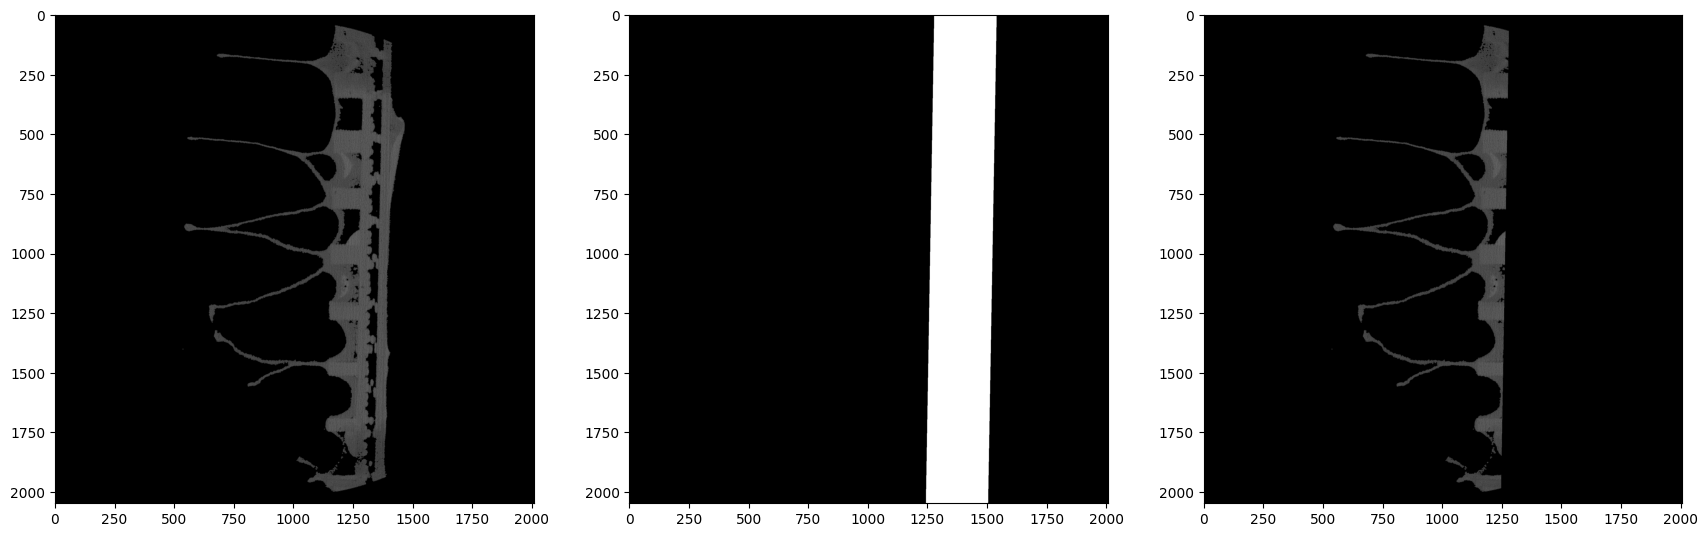

In [ ]:
img = cv2.imread('../input/s_o5/hist_threshold/tiff/149.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_o75/hist_threshold/tiff/440.tiff', cv2.IMREAD_GRAYSCALE)

plastic_mask = get_plastic_mask_sliding_window_o5x(img, True, 9)
plastic_base_masked_image_o5x = cv2.bitwise_and(img, 255 - plastic_mask)

my_imshow(1, 3, [img, plastic_mask, plastic_base_masked_image_o5x])

# Segment plastic cell edges

In [366]:
def segment_plastic_cell_edges(img, sigma, length):
    """
    This function finds and segments the plastic cell edges for an input image where the plastic base is removed.
    The image histogram is smoothed and its minima are found to identify the segmenatation threshold.

    Parameters:
    img (np.ndarray): A histogram thresholded image from the dataset.
    sigma (float): Sigma for the Gaussian convolution kernel.
    length (int): Length of Gaussian convolution kernel.
    
    Returns:
    mask (np.ndarray): Mask to use to filter out the plastic base.
    curve (np.ndarray): A 1-d numpy array containing the Gaussian smoothed histogram.
    threshold (int): Segmentation threshold for plastic cell edges.
    """
    norm = normalize(img)
    blurred_img = cv2.GaussianBlur(norm, (3, 3), 0)

    # Form the Gaussian smoothing kernel
    kernel = gaussian(length, sigma)
    kernel /= np.sum(kernel)

    # Calculate the histogram of the blurred image
    hist = cv2.calcHist([blurred_img[blurred_img > 0]],[0],None,[256],[0,256])
    hist = np.squeeze(hist)

    # Smooth the image histogram with a Gaussian kernel
    curve = np.convolve(hist, kernel, 'same')

    # Compute the minima of the smoothed image histogram and identify the threshold value
    minima = argrelextrema(curve, np.less)[0]
    threshold = minima[-1]
    # Check if minimum returned is a false positive
    if curve[threshold] > curve[threshold - 10] or curve[threshold] > curve[threshold + 10 if threshold + 10 < 256 else 255]:
        threshold = minima[-2]

    # Enhance the mask
    mask = np.where(norm > (threshold + 20), 255, 0).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)))
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)

    # Highlight the plastic cell edges
    
    
    return mask, curve, threshold

## o5x data

Plastic is segmented differently in o5x data as the previous algorithm fails due to the presence of irregular artefacts like wax and honey around the plastic cell edges.
* o5x data uses a simpler algorithm to find segment plastic regions.
* It is done by simple thresholding and morphological operations.

In [318]:
def segment_plastic_cell_edges_o5x(tiff_image):
    """
    This function finds and segments the plastic cell edges for a o5x dataset image where the plastic base is removed.
    We write a separate function for o5x becasue the dataset is not as clean and requires special handling.

    Parameters:
    tiff_image (np.ndarray): A histogram thresholded TIFF image from the o5x dataset.
    
    Returns:
    np.ndarray: Mask to use to filter out the plastic cell edges.
    """
    img = cv2.GaussianBlur(tiff_image, (5, 5), 0)

    mask = np.logical_and(img > 21000, img < 22500) * 255
    mask = mask.astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)

    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    valid_contours = []
    for contour in contours:
        if cv2.contourArea(contour) > 2000:
            valid_contours.append(contour)

    plastic_segments = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    plastic_segments = cv2.drawContours(plastic_segments, valid_contours, -1, (255, 255, 255), -1)
    plastic_segments = cv2.cvtColor(plastic_segments, cv2.COLOR_BGR2GRAY)
    plastic_segments = cv2.morphologyEx(plastic_segments, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)))
    
    return plastic_segments

## Driver function to segment plastic edges

In [ ]:
# Driver code to segment edges of plastic starter
def segment_plastic_cell_edges_driver(path, sigma = 4.0, length = 15):
    """
    Driver function to segment the plastic cell edges for the dataset images

    Parameters:
    path (string): Path to the top level directory of the dataset.
    sigma (float): Sigma for the Gaussian convolution kernel used in segment_plastic_cell_edges().
    length (int): Length of Gaussian convolution kernel used in segment_plastic_cell_edges().

    Returns:
    No return value.
    """
    tiff_dirs = get_tiff_dict(path)
        
    for tiff_dir in sorted(tiff_dirs.keys()):
        # Find the input sub-directory in the dataset directory
        if not 'plastic_base_masked' in tiff_dir:
            continue
        
        try:
            tiff_template = Image.open(f'{tiff_dir}/../../0001.tiff')
        except:
            continue # Solution dir
            
        plastic_segment_solution_path = f'{tiff_dir}/../../plastic_segmented/'

        # Create the output directory if it does not exist already
        if not os.path.isdir(plastic_segment_solution_path):
            os.makedirs(plastic_segment_solution_path)
            
        if not os.path.isdir(f'{plastic_segment_solution_path}/tiff/'):
            os.makedirs(f'{plastic_segment_solution_path}/tiff/')

        # Initialize video writer
        temp_img = cv2.imread(tiff_dirs[tiff_dir][0], cv2.IMREAD_GRAYSCALE)
        out = cv2.VideoWriter(plastic_segment_solution_path + tiff_dir.split('/')[-3] + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (temp_img.shape[1], temp_img.shape[0]))

        print('Begin plastic segmentation of ' + tiff_dir)
        for i, file in tqdm(enumerate(sorted(tiff_dirs[tiff_dir], key = lambda x: int(x.split(os.path.sep)[-1].split('.')[0])))):
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

            if path == 'wax_o5x':
                plastic_segments_mask = segment_plastic_cell_edges_o5x(img)
            else:
                plastic_segments_mask, curve, threshold = segment_plastic_cell_edges(img, sigma, length)
                
            masked_image = img
            masked_image[plastic_segments_mask == 255] = 255
            
            tiff_image = cv2.imread(file, -1)
            tiff_masked = tiff_image
            tiff_masked[plastic_segments_mask == 255] = 0xffff
            
            write_tiff(tiff_template, f'{plastic_segment_solution_path}/tiff/{i}.tiff', tiff_masked)
            out.write(cv2.cvtColor(masked_image, cv2.COLOR_GRAY2BGR))
        print('Finish plastic segmentation of ' + tiff_dir)
    
        out.release()

In [ ]:
# Segment the plastic cell edges for the required datasets
for dataset in dataset_paths:
    if os.path.isdir(dataset_root + dataset + '/plastic_base_masked'):
        segment_plastic_cell_edges_driver(dataset_root + dataset)

Begin plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_o5x/o5x_no_honey/o5x_no_honey_2022-12-26_125835/0.4X 95kVA/o5x_no_honey_0.4X 95kVA_recon/plastic_base_masked/tiff


2034it [09:22,  3.62it/s]


Finish plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_o5x/o5x_no_honey/o5x_no_honey_2022-12-26_125835/0.4X 95kVA/o5x_no_honey_0.4X 95kVA_recon/plastic_base_masked/tiff
Begin plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_o5x/wax_o5x/wax_o5x_2022-12-26_110135/0.4X 95kV/wax_o5x_0.4X 95kV_recon/plastic_base_masked/tiff


2034it [09:25,  3.60it/s]


Finish plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_o5x/wax_o5x/wax_o5x_2022-12-26_110135/0.4X 95kV/wax_o5x_0.4X 95kV_recon/plastic_base_masked/tiff
Begin plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_o75x/wax_o75_no_honey/wax_o75_no_honey_2022-12-07_122440/0.4X 90kV/wax_o75_no_honey_0.4X 90kV_recon/plastic_base_masked/tiff


2034it [09:39,  3.51it/s]


Finish plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_o75x/wax_o75_no_honey/wax_o75_no_honey_2022-12-07_122440/0.4X 90kV/wax_o75_no_honey_0.4X 90kV_recon/plastic_base_masked/tiff
Begin plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_1x/wax_1x_no_honey_trial2_2022-12-07_134615/0.4X 95kV/wax_1x_no_honey_trial2_0.4X 95kV_recon/plastic_base_masked/tiff


2034it [09:09,  3.70it/s]


Finish plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_1x/wax_1x_no_honey_trial2_2022-12-07_134615/0.4X 95kV/wax_1x_no_honey_trial2_0.4X 95kV_recon/plastic_base_masked/tiff
Begin plastic segmentation of /media/chethan749/Honeycomb1/combined/1o25/1o25_2023-10-19_141536/0.4X 85kV 17.4um/1o25_0.4X 85kV 17.4um_recon/plastic_base_masked/tiff


2034it [09:36,  3.53it/s]


Finish plastic segmentation of /media/chethan749/Honeycomb1/combined/1o25/1o25_2023-10-19_141536/0.4X 85kV 17.4um/1o25_0.4X 85kV 17.4um_recon/plastic_base_masked/tiff
Begin plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_1o5x/plastic_base_masked/tiff


2034it [09:23,  3.61it/s]


Finish plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_1o5x/plastic_base_masked/tiff
Begin plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_1o75x/1o75x_2023-08-30_121031/0.4X 95kVA/1o75x_0.4X 95kVA_recon/plastic_base_masked/tiff


2028it [09:18,  3.63it/s]


Finish plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_1o75x/1o75x_2023-08-30_121031/0.4X 95kVA/1o75x_0.4X 95kVA_recon/plastic_base_masked/tiff
Begin plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_1o75x_small/1o75_small_2023-08-30_132806/0.4X 95kVA/1o75_small_0.4X 95kVA_recon/plastic_base_masked/tiff


2034it [09:11,  3.69it/s]


Finish plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_1o75x_small/1o75_small_2023-08-30_132806/0.4X 95kVA/1o75_small_0.4X 95kVA_recon/plastic_base_masked/tiff
Begin plastic segmentation of /media/chethan749/Honeycomb1/combined/1o75-redo/1o75-redo_2023-09-28_101351/0.4X 85kV 17.4um/1o75-redo_0.4X 85kV 17.4um_recon/plastic_base_masked/tiff


2028it [09:09,  3.69it/s]


Finish plastic segmentation of /media/chethan749/Honeycomb1/combined/1o75-redo/1o75-redo_2023-09-28_101351/0.4X 85kV 17.4um/1o75-redo_0.4X 85kV 17.4um_recon/plastic_base_masked/tiff
Begin plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_2x/plastic_base_masked/tiff


1016it [01:00, 16.90it/s]


Finish plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_2x/plastic_base_masked/tiff
Begin plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_3x/zoomed_in_1/wax_3x_zoomed_in_1_recon/plastic_base_masked/tiff


2034it [09:08,  3.71it/s]


Finish plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_3x/zoomed_in_1/wax_3x_zoomed_in_1_recon/plastic_base_masked/tiff
Begin plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon/plastic_base_masked/tiff


2034it [09:48,  3.46it/s]

Finish plastic segmentation of /media/chethan749/Honeycomb1/combined/wax_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon/plastic_base_masked/tiff


## Test function `segment_plastic_cell_edges()`

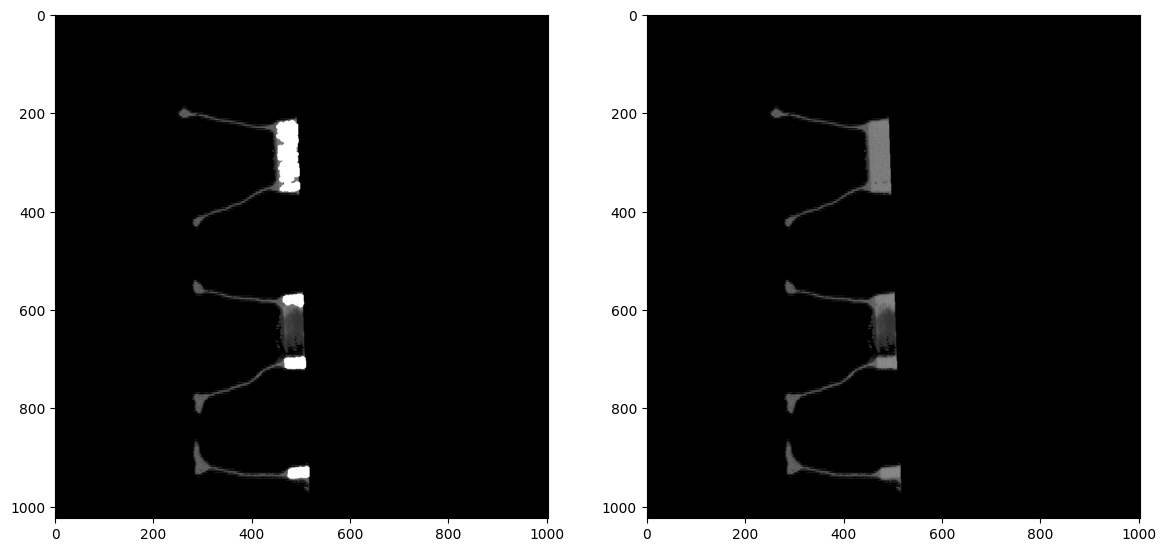

In [ ]:
# img = cv2.imread('../input/s_o75/plastic_base_masked/tiff/275.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_1/plastic_base_masked/tiff/140.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_1o25/plastic_base_masked/tiff/840.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_1o5/plastic_base_masked/tiff/410.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_1o75/plastic_base_masked/tiff/541.tiff', cv2.IMREAD_GRAYSCALE)
img = cv2.imread('../input/s_2/plastic_base_masked/tiff/367.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../input/s_3/plastic_base_masked/tiff/50.tiff', cv2.IMREAD_GRAYSCALE)

mask, curve, threshold = segment_plastic_cell_edges(img, 4, 15)
masked_image = img.copy()
masked_image[mask == 255] = 255

my_imshow(1, 2, [masked_image, img])

## Test function `segment_plastic_cell_edges_o5x()`

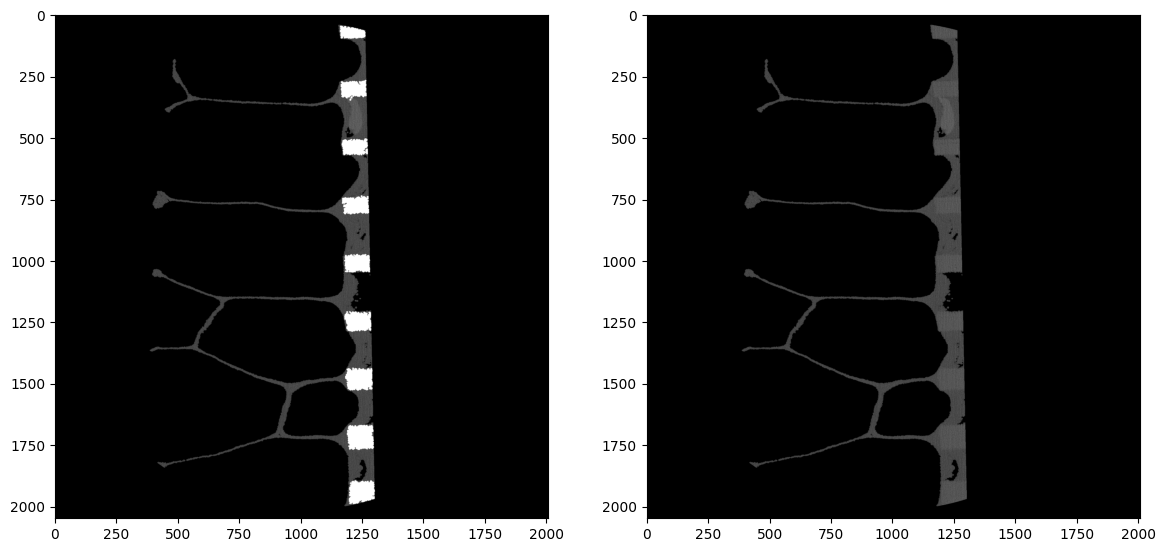

In [ ]:
path = '../input/s_o5/plastic_base_masked/tiff/1415.tiff'

img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
tiff_image = cv2.imread(path, -1)

plastic_mask = segment_plastic_cell_edges_o5x(tiff_image)
masked_image = img.copy()
masked_image[plastic_mask == 255] = 255

my_imshow(1, 2, [masked_image, img])

## Plot for plastic cell edge segmentation

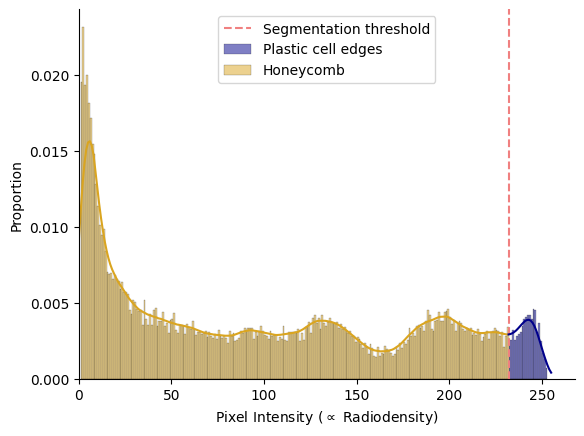

In [482]:
masked_image, curve, threshold = segment_plastic_cell_edges(img, 4, 15)
# Form a DataFrame for the input image
plastic_cell_edges_segmentation_image_df = pd.DataFrame(cv2.GaussianBlur(normalize(img), (3, 3), 0).flatten(), columns=['PixelIntensity'])
df_mask = plastic_cell_edges_segmentation_image_df.PixelIntensity < threshold
curve /= curve.sum()
# Form a DataFrame for the curve
plastic_cell_edges_segmentation_curve_df = pd.DataFrame(zip(range(len(curve)), curve), columns=['PixelIntensity', 'GaussianSmoothedHistogram'])
plastic_cell_edges_segmentation_curve_df['Segment'] = 0
plastic_cell_edges_segmentation_curve_df.loc[plastic_cell_edges_segmentation_curve_df.PixelIntensity >= threshold, 'Segment'] = 1

fig, axes = plt.subplots()

# Plot the histogram of pixel intensities in the input image, showing proportions
ax = sns.histplot(data = plastic_cell_edges_segmentation_image_df[plastic_cell_edges_segmentation_image_df.PixelIntensity > 0], x = 'PixelIntensity', binwidth = 1, stat = 'proportion', hue=df_mask, palette={True: 'goldenrod', False: 'darkblue'},
             element='bars', hue_order=[True, False], legend=True, ax = axes)
ax.axvline(x=threshold, c='lightcoral', ls='dashed', label = 'Segmentation threshold')
ax.legend(['Segmentation threshold', 'Plastic cell edges', 'Honeycomb'])#, title='Pixel intensity')

# Plot the Gaussian smoothed histogram used to find the threshold value
sns.lineplot(data=plastic_cell_edges_segmentation_curve_df, x='PixelIntensity', y='GaussianSmoothedHistogram', hue='Segment', palette={0: 'goldenrod', 1: 'darkblue'}, legend=None)

ax.set_xlim(left = 0)

ax.set_xlabel(r'Pixel Intensity ($\propto$ Radiodensity)')
sns.despine()
ax.figure.savefig('figures/plastic_histogram_segmentation.png', dpi=600)

# Dragonfly documentation

### Learning resource
[Dragonfly tutorials](https://youtube.com/playlist?list=PLbYyniU4wPOtHGT0m68liH5SntwfETKsP) - This is a great resource and probably the only truly extensive one out there. You would not need to watch all videos as we do most of your processing here in the notebook and use Dragonfly mainly for viusalization purposes. Here's a list of concepts that you would need to pick up:
* Working with images in Dragonfly (Window leveling, basic thresholding etc.)
* ROIs
* Adding planes, boxes and clipping your dataset using these shapes
* Dragonfly MovieMaker
* Morphological operations like opening, closing, smoothing etc.
You should be able to find most of these concepts within the first 12-13 videos in the playlist.

### Dragonfly techniques for honeycomb analysis

#### Window leveling
* This can be performed in the `Window Leveling` tab under the `Main` tab in the tools panel on the left.
* We use it to improve contrast, hide a range of undesired pixel values etc. (more information on this can be found in the tutorials above)
* This setting can be applied to both 2-D and 3-D data based on the window that is selected.

#### Visualizing with colors
* Different color schemes could be applied to the data by selecting the appropriate color scheme from the dropdown menu under the `Lookup table (LUT)` tab on the left panel.
* For 3-D we use the color scheme `32-colors` and for 2-D we use `blue-green-red`.
* Check the images in the hard-drive to get an idea of the color scheme we use for the processed data. This can be achieved by choosing the color schemes mentioned above and tinkering with the sliders under the histogram in the `Window Leveling` tab.
* Adjusting lighting in the `Lighting` tab on the left tool panel may help in certain situations.

#### Clipping 3-D data with shapes
* A shape can be applied/superimposed onto the data by selecting a shape from the `Shapes` menu at the top.
* Once the shape is applied, it is visible in the `Properties` panel on the right.
* The shape can be rotated and its surfaces can be adjusted as required in the 3-D window.
* To clip dataset based on the shape, select the shape under `Properties`. Under `Visuals`, select the dataset you want to apply the clipping on. Typically you should see only one unless you have loaded multiple datasets.
* Select `Clip` under 3-D effects. You might need to check/uncheck `Outside` based on the kind of clipping you need.
* For planes, you can check the `Solid` option under `Plane Settings` in the tool panel on the right based on the kind of visualization needed.

#### Making movies
* Use the MovieMaker tutorial as a reference, you will find everything you need there.

#### Some general tips
* Switch between the *cross-hair* icon and the *four-arrows* icon to show or hide axes in the 2-D panels. This may come in handy when taking screenshots.
* Select the dataset under the `Properties` panel, select the 3-D panel/tile from the central window and play around with settings like `Edge contrast`, `Tone mapping`, `Solidity` etc. to get the desired visualization of the 3-D data.
* **IMPORTANT**: Save sessions for any long sequence of operations applied - it will save you a lot of time and repeated effort.

<!-- ### Directory structure in the hard drive

All data is present under the `combined` directory.
- combined
    - wax_\<*size*\> - Parent directory for size *size*
        - Find the directory containnig `n.tiff` images, where `n` is of the form 0000, 0001, 0002, ... , 1012/2034
        - `n.tiff` is the raw X-ray data.
        - `hist_threshold` - Contains the results of histogram thresholding for this dataset
        - `plastic_base_masked` - Contains the result of removing plastic starter base using LBM template matching for the dataset
        - `plastic_segmented` - Contains the result of plastic 'teeth' segmentation for the dataset
        - `slice` - Contains new slice created for angle analysis and the results of the same
        - `images` - Dragonfly screenshots for the dataset
        - `movies` - Movies generated in Dragonfly for the dataset
        - `bgs` - Experimentation on using background subtraction to extract foreground. **Ignore this** - not used anymore.
        - `roi` - Binary segmentation results for the dataset. **Ignore this** - not used at the moment. -->